# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [3]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [4]:
#acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# pd.set_option('display.max_colwidth', -1)


In [6]:
# how many spam and ham observations do we have?

df.label.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 130.6+ KB


In [8]:
# combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

## Exploration

Represent text as word frequencies.

In [9]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [10]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [11]:
# sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,ham,spam,all
i,2305,45,2350
to,1554,686,2240
you,1837,287,2124
a,1055,376,1431
the,1118,204,1322
u,986,147,1133
and,848,122,970
is,728,158,886
in,811,73,884
me,756,30,786


In [12]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham', 'spam'], ascending=[True, False]).head(20)

,ham,spam,all
claim,0,113,113
prize,0,92,92
won,0,73,73
guaranteed,0,50,50
tone,0,48,48
18,0,43,43
awarded,0,38,38
a1000,0,35,35
150ppm,0,34,34
a2000,0,31,31


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

Text(0.5, 1.0, 'Ham vs Spam count for the top 20 most frequent words')

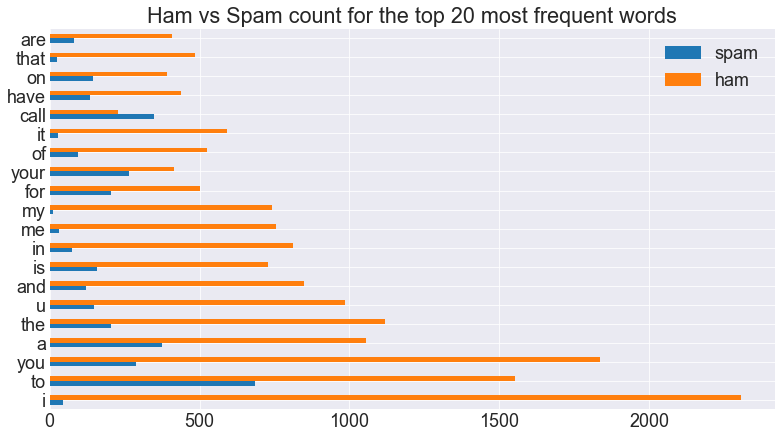

In [13]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['spam', 'ham']].plot.barh()
plt.title('Ham vs Spam count for the top 20 most frequent words')

Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

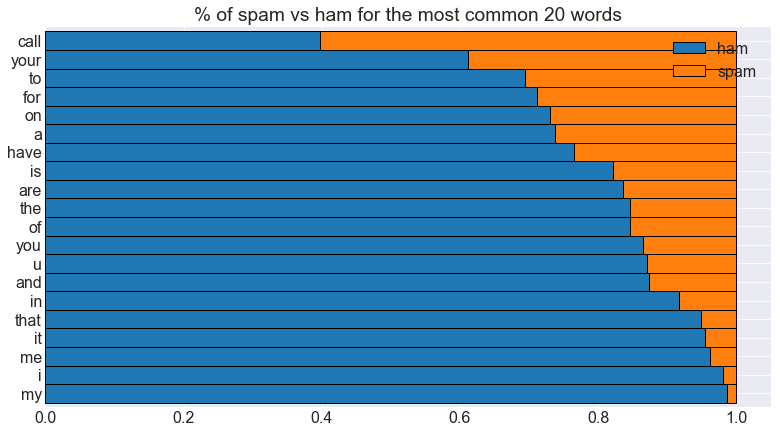

In [14]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of spam vs ham for the most common 20 words')

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [15]:
sentence = 'Today is tuesday, and the weather is nice.'

In [16]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

In [17]:
# Don't do this!
# list(nltk.bigrams(sentence))

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

Text(0.5, 1.0, 'Top 10 most common spam bigrams')

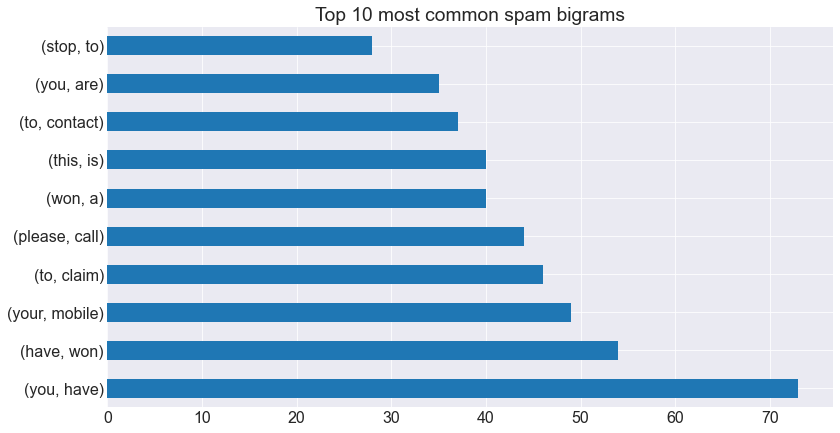

In [18]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common spam bigrams')

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

(-0.5, 799.5, 599.5, -0.5)

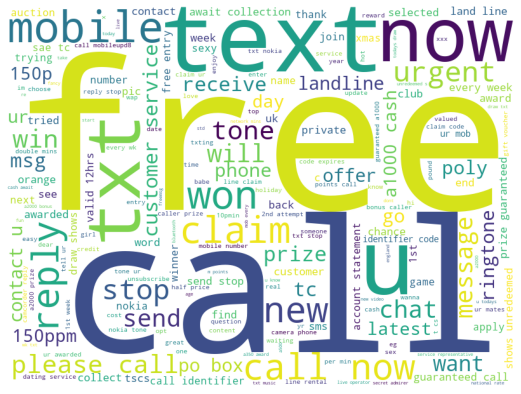

In [19]:
from wordcloud import WordCloud
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img)
plt.axis('off')

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [ ]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df.text.apply(len)

df['word_count'] = df.text.apply(clean).apply(str.split).apply(len)

df.head()

In [ ]:
sns.relplot(data = df, x = 'message_length', y = 'word_count', hue = 'label')

In [ ]:
df.groupby('label').message_length.agg(['mean', 'median'])

## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [20]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [21]:
sia.polarity_scores('He is really good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [22]:
sia.polarity_scores('He is REALLY good')

{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}

In [23]:
sia.polarity_scores('He is very good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [24]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [25]:
sia.polarity_scores('He is good :-)')

{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}

In [26]:
sia.polarity_scores('The food SUX')

{'neg': 0.618, 'neu': 0.382, 'pos': 0.0, 'compound': -0.4995}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [27]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,label,text,sentiment
id,,,
0,ham,"Go until jurong point, crazy.. Available only ...",0.6249
1,ham,Ok lar... Joking wif u oni...,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.7964
3,ham,U dun say so early hor... U c already then say...,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",-0.1027
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,0.0000
5569,ham,"Pity, * was in mood for that. So...any other s...",-0.2960


In [ ]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median'])

In [ ]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

In [ ]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam');

In [ ]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True )
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 )

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)